In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import imageio
import os
from tqdm import tqdm  # For progress bars
# File naming convention: filename = "run_α=(α)_N²=(N²)_M²=(M²).nc"
filename = 'run_Ro=δ=0_Ro=0.1_F=0.5.nc' #remember.nc at the end
ds = xr.open_dataset(filename, engine = 'netcdf4', decode_times=False)


## Non-dimensionalising timescale

In [27]:
f = 1e-4

# Rescale time: convert seconds to non-dimensional time = f * t
# Ensure 'time' is in seconds (if it's in days, convert to seconds first)
time_in_seconds = ds.time.values.astype('timedelta64[s]').astype(float)
nondim_time = f * time_in_seconds


# Add non-dimensional time to dataset for convenience
ds = ds.assign_coords(nondim_time=("time", nondim_time))

## Buoyancy Animation

In [28]:
import matplotlib.pyplot as plt
import xarray as xr
import imageio
import os
from tqdm import tqdm  # For progress bars

b = ds['b'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_caa.values / 1e3 
sponge_width = 0.2 * x_km.max()  # Sponge layer position

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, b_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"Time = {ds.time[i].values/86400:.2f} days",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-sponge_width, color='0.5', linestyle='--')
    ax.axvline(sponge_width, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_animation_new.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 147/147 [00:44<00:00,  3.34it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_25032\1837319084.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1073, 586) to (1088, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Backup Animation (takes longer)

In [29]:
""""


b = ds['b']
x = ds['x_caa'].values / 1e3  # convert to km
z = ds['z_aac'].values
time_values = ds['time'].values

# === Prepare a folder for frames ===
os.makedirs("frames", exist_ok=True)

# === Create frames ===
images = []
for i in range(len(time_values)):
    plt.figure(figsize=(8, 4))
    ax = plt.gca()

    # Get 2D buoyancy data at time i
    b_data = b.isel(time=i ).values

    # Filled color map
    pc = ax.pcolormesh(x, z, b_data, shading='auto', cmap='RdBu_r',
                       vmin=float(b.min()), vmax=float(b.max()))
    plt.colorbar(pc, ax=ax, label="b (m/s²)")

    # Contour lines
    contour_levels = 10  # or use a list like [-1e-4, -5e-5, 0, 5e-5, 1e-4]
    cs = ax.contour(x, z, b_data, levels=contour_levels, colors='black', linewidths=0.5)
    #ax.clabel(cs, inline=True, fontsize=6, fmt="%.0e")

    # Title and labels
    plt.title(f"Time = {time_values[i]/86400:.2f}, " + filename)
    ax.set_xlabel("x (km)")
    ax.set_ylabel("z (m)")
    #ax.set_xlim(-100, 100) #comment this out to change width of animation
    ax.axvline(-x.max() + 2*x.max()/10 ) # left sponge layer. (note the factor of 2 becuase x.max() is Lx/2)
    ax.axvline(x.max() - 2*x.max()/10) #right sponge layer
    
    # Save frame
    frame_path = f"frames/frame_{i:04d}.png"
    plt.savefig(frame_path, dpi=150)
    images.append(imageio.imread(frame_path))
    plt.close()

# === Save as animation ===
imageio.mimsave(filename + '_animation.mp4', images, fps=5)

print("✅ Animation saved as 'buoyancy_animation.mp4' with buoyancy contours.")
"""


'"\n\n\nb = ds[\'b\']\nx = ds[\'x_caa\'].values / 1e3  # convert to km\nz = ds[\'z_aac\'].values\ntime_values = ds[\'time\'].values\n\n# === Prepare a folder for frames ===\nos.makedirs("frames", exist_ok=True)\n\n# === Create frames ===\nimages = []\nfor i in range(len(time_values)):\n    plt.figure(figsize=(8, 4))\n    ax = plt.gca()\n\n    # Get 2D buoyancy data at time i\n    b_data = b.isel(time=i ).values\n\n    # Filled color map\n    pc = ax.pcolormesh(x, z, b_data, shading=\'auto\', cmap=\'RdBu_r\',\n                       vmin=float(b.min()), vmax=float(b.max()))\n    plt.colorbar(pc, ax=ax, label="b (m/s²)")\n\n    # Contour lines\n    contour_levels = 10  # or use a list like [-1e-4, -5e-5, 0, 5e-5, 1e-4]\n    cs = ax.contour(x, z, b_data, levels=contour_levels, colors=\'black\', linewidths=0.5)\n    #ax.clabel(cs, inline=True, fontsize=6, fmt="%.0e")\n\n    # Title and labels\n    plt.title(f"Time = {time_values[i]/86400:.2f}, " + filename)\n    ax.set_xlabel("x (km)")\n  

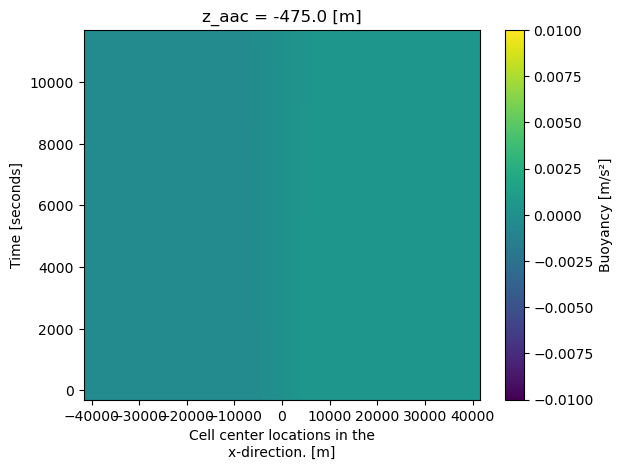

In [30]:
ds.b[:20,10,100:140].plot(vmin = -0.01, vmax = 0.01)

In [31]:
ds

<xarray.Dataset> Size: 29MB
Dimensions:      (x_caa: 240, x_faa: 241, z_aac: 20, z_aaf: 21, time: 293)
Coordinates:
  * time         (time) float64 2kB 0.0 600.0 1.2e+03 ... 1.746e+05 1.752e+05
  * x_faa        (x_faa) float32 964B -2.5e+05 -2.479e+05 ... 2.479e+05 2.5e+05
  * x_caa        (x_caa) float32 960B -2.49e+05 -2.469e+05 ... 2.49e+05
  * z_aaf        (z_aaf) float32 84B -1e+03 -950.0 -900.0 ... -100.0 -50.0 0.0
  * z_aac        (z_aac) float32 80B -975.0 -925.0 -875.0 ... -125.0 -75.0 -25.0
    nondim_time  (time) float64 2kB 0.0 0.06 0.12 0.18 ... 17.4 17.46 17.52
Data variables:
    Δx_caa       (x_caa) float32 960B ...
    Δx_faa       (x_faa) float32 964B ...
    Δz_aac       (z_aac) float32 80B ...
    Δz_aaf       (z_aaf) float32 84B ...
    b            (time, z_aac, x_caa) float32 6MB -0.000975 -0.000975 ... 0.1652
    u            (time, z_aac, x_faa) float32 6MB ...
    v            (time, z_aac, x_caa) float32 6MB ...
    w            (time, z_aaf, x_caa) float32 6MB ...
    ζ            (time, z_aaf, x_faa) float32 6MB ...
Attributes:
    Julia:                 This file was generated using Julia Version 1.11.5...
    Oceananigans:          This file was generated using Oceananigans v0.96.35
    date:                  This file was generated on 2025-07-18T15:42:40.818...
    interval:              600.0
    output time interval:  Output was saved every 10 minutes.
    schedule:              TimeInterval